This kernel explores details of the training data to find out interesting insights in the data and lead ideas for feature engineering. Although the test dataset is not clearly presented in the original setting, i produced test data in the kernel (https://www.kaggle.com/taichin/testdata-generation) to check the difference between training data and test data. the data considers only games in regular season.

In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
import seaborn as sns
import pandas_profiling as pdp
from datetime import datetime
import tqdm
import category_encoders as ce
import matplotlib.patches as patches
import math
import time
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d, ConvexHull
pd.set_option("display.max_columns",1000)

In [2]:
env = nflrush.make_env()

In [3]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)
#test_df = pd.read_csv('/kaggle/input/nfl-big-data-2019/test.csv', low_memory=False)
#train_2017 = train_df[train_df.Season==2017]
#train_2018 = train_df[train_df.Season==2018]

At first, let's check the contents of training data. The training data includes 509762 plays and 49 variables such as GameId and PlayId.

In [4]:
print(train_df.shape)
train_df.head(2)

(509762, 49)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [5]:
print(test_df.shape)
test_df.head(2)

NameError: name 'test_df' is not defined

The following command checks data type of each variable in the data. 15 int variables, 24 object variables and 10 float variables.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

# univariate analysis
At first, we check the distribution of each variable without considering dependencies between variables. As you can see, all variables are non-negative.

In [7]:
train_df.describe()

,GameId,PlayId,X,Y,S,A,Dis,Orientation,Dir,NflId,JerseyNumber,Season,YardLine,Quarter,Down,Distance,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,Yards,PlayerWeight,Week,Temperature,Humidity
count,5.097620e+05,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509744.000000,509748.000000,5.097620e+05,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,509762.000000,5.097620e+05,509696.000000,509762.000000,509762.000000,509762.000000,461230.000000,503602.000000
mean,2.017594e+09,2.017594e+13,60.040304,26.783535,2.591912,1.683176,0.279406,180.247779,179.933859,2.344703e+06,54.187982,2017.486427,28.368737,2.504639,1.520651,8.329248,11.148073,9.501057,2.419204e+06,6.943025,4.212334,253.554388,9.096370,60.436442,55.646062
std,4.997098e+05,4.997098e+09,25.435261,7.238206,1.383601,0.976412,0.145482,104.298330,106.319488,6.418871e+05,28.379359,0.499816,13.010918,1.144105,0.674987,3.795208,10.277098,9.366413,5.357783e+05,0.991130,6.436167,48.367386,5.000984,17.570291,25.430976
min,2.017091e+09,2.017091e+13,0.660000,1.850000,0.000000,0.000000,0.000000,0.000000,0.000000,2.220000e+02,1.000000,2017.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.340000e+02,1.000000,-14.000000,153.000000,1.000000,9.000000,0.000000
25%,2.017111e+09,2.017111e+13,39.090000,22.730000,1.500000,0.940000,0.170000,90.630000,89.830000,2.532865e+06,26.000000,2017.000000,20.000000,1.000000,1.000000,6.000000,3.000000,0.000000,2.540011e+06,6.000000,1.000000,210.000000,5.000000,48.000000,43.000000
50%,2.017123e+09,2.017123e+13,60.290000,26.790000,2.470000,1.540000,0.270000,179.700000,180.090000,2.543765e+06,56.000000,2017.000000,29.000000,3.000000,1.000000,10.000000,9.000000,7.000000,2.552582e+06,7.000000,3.000000,245.000000,9.000000,62.000000,59.000000
75%,2.018110e+09,2.018110e+13,80.970000,30.860000,3.560000,2.290000,0.390000,270.400000,270.190000,2.555343e+06,78.000000,2018.000000,39.000000,4.000000,2.000000,10.000000,17.000000,14.000000,2.557976e+06,8.000000,6.000000,305.000000,14.000000,73.000000,71.000000
max,2.018123e+09,2.018123e+13,116.840000,56.450000,9.410000,14.710000,1.390000,360.000000,360.000000,2.561671e+06,99.000000,2018.000000,50.000000,5.000000,4.000000,40.000000,57.000000,51.000000,2.561468e+06,11.000000,99.000000,380.000000,17.000000,97.000000,100.000000


In [8]:
test_df.describe()

NameError: name 'test_df' is not defined

In [9]:
train_2017.describe()

NameError: name 'train_2017' is not defined

In [10]:
train_2018.describe()

NameError: name 'train_2018' is not defined

In [11]:
# standard deviation
std_zero_feature = []
for i in [i for i in train_df.columns if train_df[i].dtype != "object"]:
    if train_df[i].std() == 0:
        std_zero_feature.append(i)
print("std zero features: {}" .format(len(std_zero_feature))) 

std zero features: 0


In [12]:
# missing values (includes 8 missing values. possibly, the values of FieldPosition and DefendersInTheBox can be calculated?)
missing_df = train_df.isnull().sum()
print(missing_df[missing_df > 0])

missing_2017 = train_2017.isnull().sum()
print(missing_2017[missing_2017 > 0])

missing_2018 = train_2018.isnull().sum()
print(missing_2018[missing_2018 > 0])

Orientation             18
Dir                     14
FieldPosition         6424
OffenseFormation       110
DefendersInTheBox       66
StadiumType          32934
GameWeather          43648
Temperature          48532
Humidity              6160
WindSpeed            67430
WindDirection        80234
dtype: int64


NameError: name 'train_2017' is not defined

In [13]:
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])

NameError: name 'test_df' is not defined

The distribution of yards is skewed. the median of yards is 3 yards.

In [14]:
# yards
print(train_df["Yards"].median())
print(train_2017["Yards"].median())
print(train_2018["Yards"].median())
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(train_df["Yards"])
plt.subplot(1,2,2)
sns.distplot(train_2017["Yards"], label="2017")
sns.distplot(train_2018["Yards"], label="2018")
plt.legend()

3.0


NameError: name 'train_2017' is not defined

In [15]:
train_df[train_df.Yards==0].shape[0] / train_df.shape[0]

0.09257261231712054

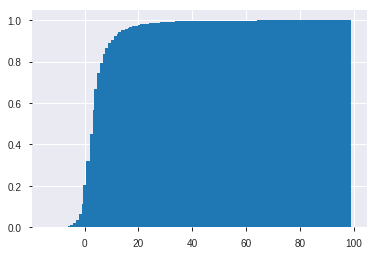

In [16]:
train = train_df.drop_duplicates(subset="PlayId") 
dist = train["Yards"].hist(density = True, cumulative = True, bins = 200)

In [17]:
train_own = train[train["FieldPosition"] == train["PossessionTeam"]]
train_other = train[train["FieldPosition"] != train["PossessionTeam"]]

own_cdf = np.histogram(train_own["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()
other_cdf = np.histogram(train_other["Yards"], bins=199, range=(-99,100), density=True)[0].cumsum()

Despite the fact that the cumulative distributions of yards seem similar, when we check the values in detail, the values are clearly different. When the value of field position and possessionteam is different, there's no chance that team progress the last 50 yards.

Text(0.5, 1.0, 'Other cdf')

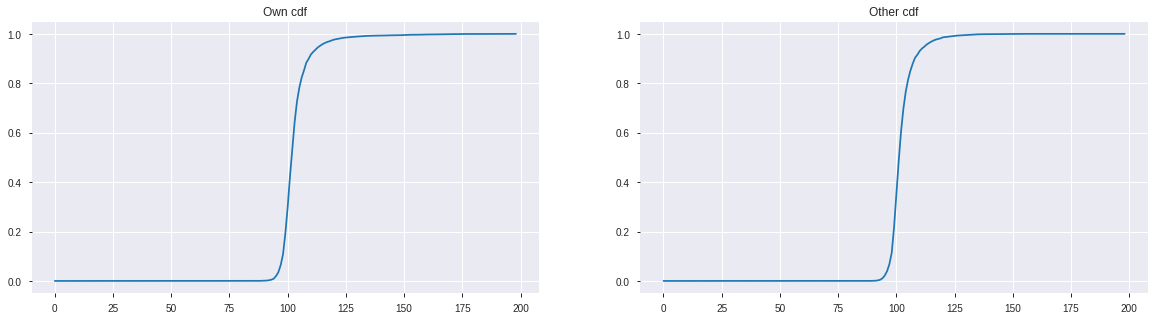

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(own_cdf)
plt.title("Own cdf")
plt.subplot(1,2,2)
plt.plot(other_cdf)
plt.title("Other cdf")

In [19]:
# own_cdf
# other_cdf

In [20]:
plt.figure(figsize=(18,8))
tmp_df = train_df["Orientation"].dropna()
#tmp_2017 = train_2017["Orientation"].apply(lambda x: 360+x-90 if x<=90 else x - 90).dropna() 
#tmp_2017 = train_2017["Orientation"].apply(lambda x: x+ 90 - 360 if x>270 else x + 90).dropna() 
tmp_2017 = train_2017["Orientation"].dropna()
tmp_2018 = train_2018["Orientation"].dropna()
tmp_test = test_df["Orientation"].dropna()
plt.subplot(2, 2, 1)
sns.distplot(tmp_df, label="training")
plt.legend()
plt.subplot(2, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
#sns.distplot(tmp_test, label="test")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x576 with 0 Axes>

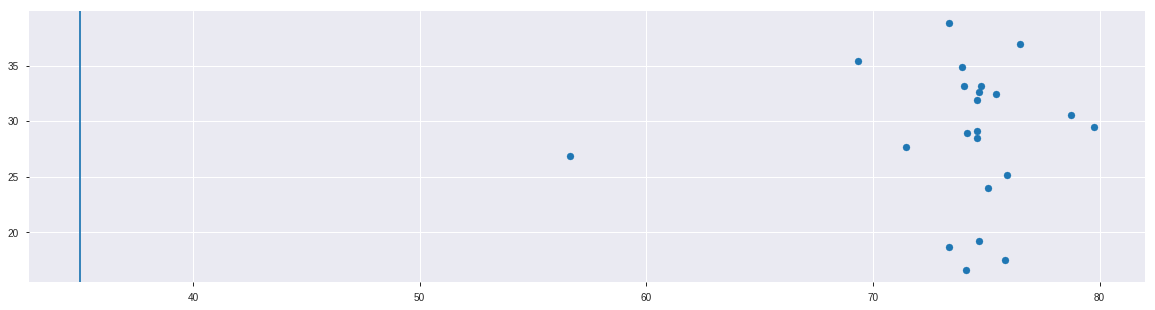

In [21]:
plt.figure(figsize=(20,5))
plt.scatter(train_df.iloc[0:22]["X"], train_df.iloc[0:22]["Y"])
plt.axvline(train_df.iloc[1]["YardLine"])

NameError: name 'train_2017' is not defined

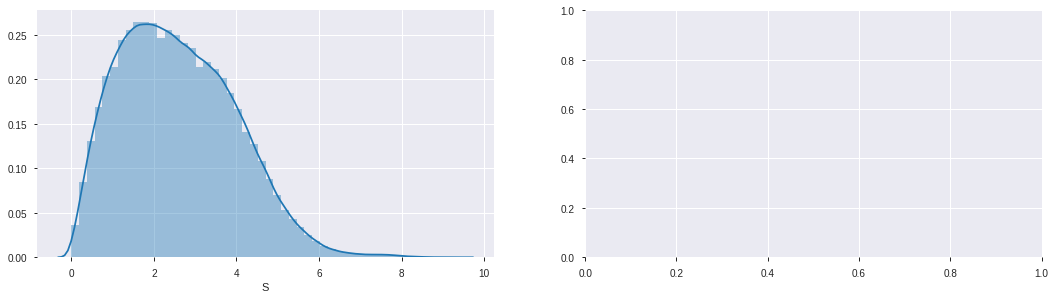

In [22]:
# S: player spped: faster in 2018 than in 2017
plt.figure(figsize=(18,10))
plt.subplot(2, 2, 1)
sns.distplot(train_df["S"])
plt.subplot(2, 2, 2)
sns.distplot(train_2017["S"], label = "2017")
sns.distplot(train_2018["S"], label = "2018")
sns.distplot(test_df["S"], label = "test")
plt.legend()

NameError: name 'train_2017' is not defined

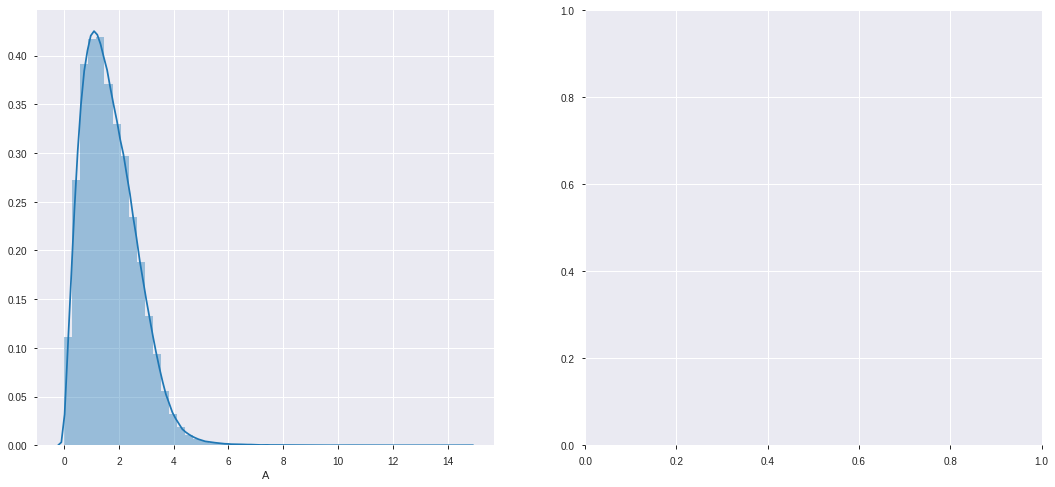

In [23]:
# A: acceleration, higher in 2018 than in 2017
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
sns.distplot(train_df["A"])
plt.subplot(1, 2, 2)
sns.distplot(train_2017["A"], label = "2017")
sns.distplot(train_2018["A"], label = "2018")
sns.distplot(test_df["A"], label = "test")
plt.legend()

NameError: name 'train_2017' is not defined

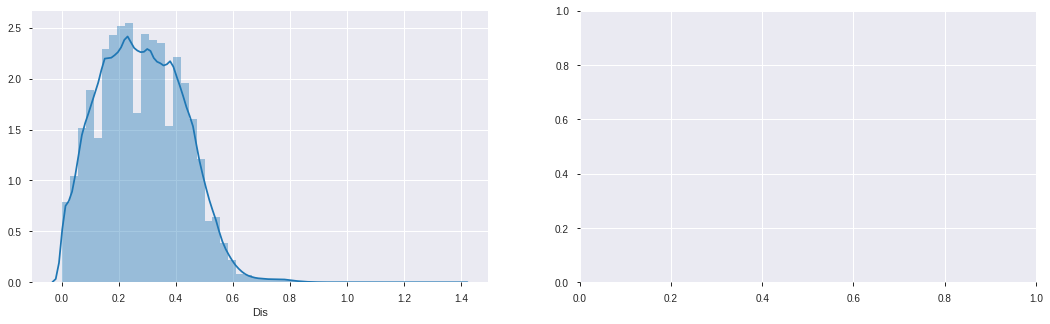

In [24]:
# Dis: distance moved from the previous point
plt.figure(figsize=(18,5))
plt.subplot(1, 2, 1)
sns.distplot(train_df["Dis"])
plt.subplot(1, 2, 2)
sns.distplot(train_2017["Dis"], label = "2017")
sns.distplot(train_2018["Dis"], label = "2018")
sns.distplot(test_df["Dis"], label = "test")
plt.legend()

In [25]:
# Dir: angle of player motion
plt.figure(figsize=(18,5))
tmp_df = train_df["Dir"].dropna()
tmp_2017 = train_2017["Dir"].dropna()
tmp_2018 = train_2018["Dir"].dropna()
tmp_test = test_df["Dir"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.legend()
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x360 with 0 Axes>

In [26]:
plt.figure(figsize=(18,5))
tmp_df = train_df["NflId"].dropna()
tmp_2017 = train_2017["NflId"].dropna()
tmp_2018 = train_2018["NflId"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x360 with 0 Axes>

In [27]:
plt.figure(figsize=(18,5))
tmp_df = train_df["JerseyNumber"].dropna()
tmp_2017 = train_2017["JerseyNumber"].dropna()
tmp_2018 = train_2018["JerseyNumber"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x360 with 0 Axes>

In [28]:
plt.figure(figsize=(18,5))
tmp_df = train_df["Season"].dropna()
tmp_test = test_df["Season"].dropna()
plt.subplot(1, 2, 1)
sns.countplot(tmp_df)
plt.subplot(1, 2, 2)
sns.countplot(tmp_test)

NameError: name 'test_df' is not defined

<Figure size 1296x360 with 0 Axes>

In [29]:
# yardline： scrimmage line (line between offense and defense. ball is set on the line and attack starts when the ball moves
plt.figure(figsize=(18,5))
tmp_df = train_df[train_df.columns[14]].dropna()
tmp_2017 = train_2017[train_2017.columns[14]].dropna()
tmp_2018 = train_2018[train_2018.columns[14]].dropna()
tmp_test = test_df[test_df.columns[14]].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x360 with 0 Axes>

In [30]:
plt.figure(figsize=(18,5))
tmp_df = train_df["Quarter"].dropna()
tmp_2017 = train_2017["Quarter"].dropna()
tmp_2018 = train_2018["Quarter"].dropna()
tmp_test = test_df["Quarter"].dropna()
plt.subplot(1, 2, 1)
sns.distplot(tmp_df)
plt.subplot(1, 2, 2)
sns.distplot(tmp_2017, label="2017")
sns.distplot(tmp_2018, label="2018")
sns.distplot(tmp_test, label="test")
plt.legend()

NameError: name 'train_2017' is not defined

<Figure size 1296x360 with 0 Axes>

In [31]:
train_df["PossessionTeam"].value_counts()          

NE     18700
LA     17952
BLT    17864
JAX    17490
NO     17490
SEA    17094
DAL    16918
HST    16764
MIN    16742
LAC    16698
DEN    16654
TEN    16544
PHI    16478
CHI    16368
BUF    16214
SF     16192
IND    16060
NYG    15642
DET    15554
NYJ    15532
ATL    15488
OAK    15422
PIT    15312
WAS    15092
ARZ    15092
KC     14300
CIN    14278
TB     14212
MIA    14168
CAR    14146
CLV    14102
GB     13200
Name: PossessionTeam, dtype: int64

In [32]:
train_df["Down"].value_counts()

1    292666
2    172986
3     39908
4      4202
Name: Down, dtype: int64

NameError: name 'train_2017' is not defined

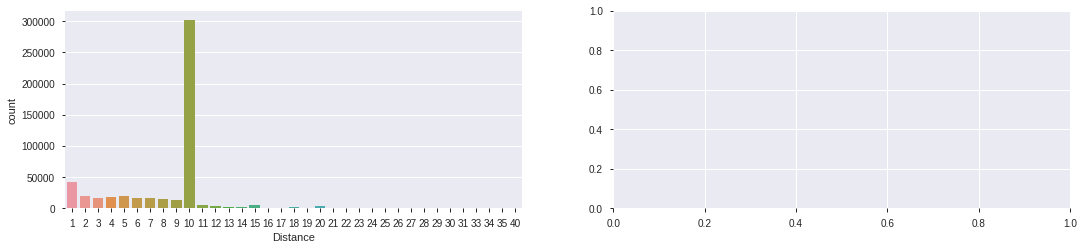

In [33]:
# Distance: the distance necessary for first down (10 yards in 4 attacks)
plt.figure(figsize=(18,8))
plt.subplot(2, 2, 1)
sns.countplot(train_df["Distance"])
plt.subplot(2, 2, 2)
sns.countplot(train_2017["Distance"])
plt.legend()
plt.subplot(2, 2, 3)
sns.countplot(train_2018["Distance"])
plt.legend()
plt.subplot(2, 2, 4)
sns.countplot(test_df["Distance"])

In [34]:
print(train_df["FieldPosition"].value_counts())

BUF    17468
OAK    17182
NYG    17160
ARZ    17072
MIA    16984
NYJ    16896
CLV    16676
CIN    16588
DEN    16566
SF     16456
SEA    16412
HST    16346
CHI    16060
IND    16038
TEN    15972
GB     15862
LA     15818
JAX    15620
DAL    15576
WAS    15554
DET    15444
BLT    15356
TB     15246
MIN    15158
LAC    15114
ATL    14938
KC     14784
NE     14718
PIT    14366
PHI    13442
NO     13332
CAR    13134
Name: FieldPosition, dtype: int64


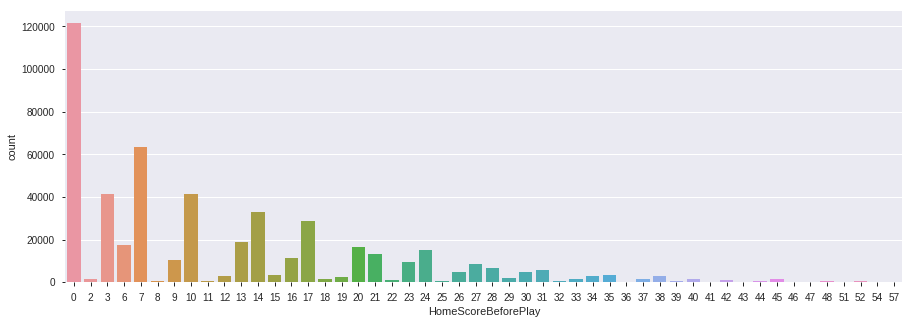

In [35]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["HomeScoreBeforePlay"])

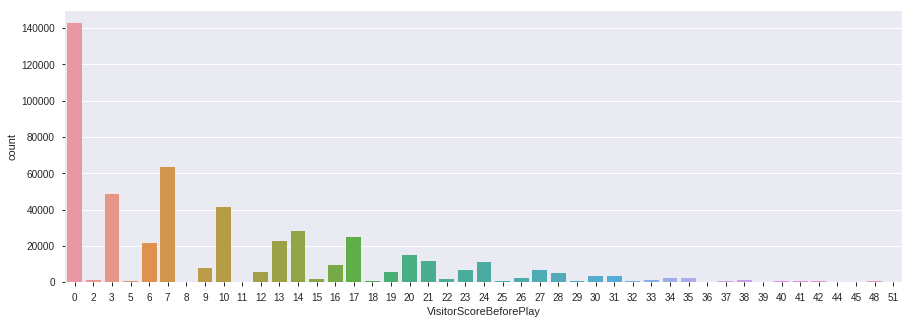

In [36]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["VisitorScoreBeforePlay"])

In [37]:
# NflIdrusher: 
print(train_df[train_df.columns[23]].value_counts())

2555224    11814
2552475    11726
2555418    11396
2552469    10010
2557917     9900
           ...  
2543477       22
2561358       22
2557863       22
2543475       22
2506931       22
Name: NflIdRusher, Length: 371, dtype: int64


In [38]:
print(train_df["OffenseFormation"].value_counts())
print(train_2017["OffenseFormation"].value_counts())
print(train_2018["OffenseFormation"].value_counts())
print(test_df["OffenseFormation"].value_counts()) # ace and single back are the same formation

SINGLEBACK    225434
SHOTGUN       150964
I_FORM        106062
PISTOL         13420
JUMBO          11462
WILDCAT         1782
EMPTY            506
ACE               22
Name: OffenseFormation, dtype: int64


NameError: name 'train_2017' is not defined

In [39]:
# OffensePersonel: position group in offense team (RB, TE, WR, OL, DL, QB)
print(train_df["OffensePersonnel"].value_counts())

1 RB, 1 TE, 3 WR               232958
1 RB, 2 TE, 2 WR               114092
2 RB, 1 TE, 2 WR                53636
1 RB, 3 TE, 1 WR                31306
2 RB, 2 TE, 1 WR                25828
6 OL, 1 RB, 2 TE, 1 WR           9680
6 OL, 1 RB, 1 TE, 2 WR           8426
6 OL, 2 RB, 1 TE, 1 WR           5896
6 OL, 2 RB, 2 TE, 0 WR           3762
2 RB, 0 TE, 3 WR                 3454
1 RB, 2 TE, 1 WR,1 DL            3102
6 OL, 1 RB, 0 TE, 3 WR           2178
1 RB, 0 TE, 4 WR                 1870
0 RB, 1 TE, 4 WR                 1672
2 QB, 1 RB, 1 TE, 2 WR           1562
2 RB, 3 TE, 0 WR                 1408
6 OL, 1 RB, 3 TE, 0 WR           1210
6 OL, 2 RB, 0 TE, 2 WR           1056
1 RB, 1 TE, 2 WR,1 DL             748
7 OL, 1 RB, 0 TE, 2 WR            682
3 RB, 1 TE, 1 WR                  572
2 QB, 2 RB, 1 TE, 1 WR            550
1 RB, 3 TE, 0 WR,1 DL             440
6 OL, 1 RB, 2 TE, 0 WR,1 DL       352
3 RB, 0 TE, 2 WR                  286
2 QB, 1 RB, 2 TE, 1 WR            264
6 OL, 1 RB, 

In [40]:
# defenders in the box: no of defenders in scrimmage line
tmp_df = train_df["DefendersInTheBox"].dropna()
tmp_test = test_df["DefendersInTheBox"].dropna()
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.countplot(tmp_df)
plt.subplot(1,2,2)
sns.countplot(tmp_test)

NameError: name 'test_df' is not defined

In [41]:
# defence personnel: group of defense position
print(train_df["DefensePersonnel"].value_counts())
print(test_df["DefensePersonnel"].value_counts())

4 DL, 2 LB, 5 DB          139876
4 DL, 3 LB, 4 DB          136510
3 DL, 4 LB, 4 DB           80432
2 DL, 4 LB, 5 DB           56936
3 DL, 3 LB, 5 DB           48884
2 DL, 3 LB, 6 DB           11638
4 DL, 1 LB, 6 DB            9196
4 DL, 4 LB, 3 DB            5214
3 DL, 2 LB, 6 DB            4246
5 DL, 2 LB, 4 DB            3542
5 DL, 3 LB, 3 DB            2376
1 DL, 4 LB, 6 DB            1430
3 DL, 5 LB, 3 DB            1408
6 DL, 4 LB, 1 DB            1232
5 DL, 4 LB, 2 DB            1166
6 DL, 3 LB, 2 DB            1034
5 DL, 1 LB, 5 DB             902
6 DL, 2 LB, 3 DB             704
1 DL, 5 LB, 5 DB             682
2 DL, 5 LB, 4 DB             484
2 DL, 2 LB, 7 DB             286
1 DL, 3 LB, 7 DB             286
3 DL, 1 LB, 7 DB             264
5 DL, 3 LB, 2 DB, 1 OL       154
5 DL, 5 LB, 1 DB             154
0 DL, 5 LB, 6 DB             132
4 DL, 5 LB, 2 DB             110
0 DL, 4 LB, 7 DB              88
2 DL, 4 LB, 4 DB, 1 OL        66
5 DL, 4 LB, 1 DB, 1 OL        66
4 DL, 0 LB

NameError: name 'test_df' is not defined

In [42]:
print(train_df["PlayDirection"].value_counts())
print(train_2017["PlayDirection"].value_counts())
print(train_2018["PlayDirection"].value_counts())
print(test_df["PlayDirection"].value_counts())

left     256454
right    253308
Name: PlayDirection, dtype: int64


NameError: name 'train_2017' is not defined

In [43]:
# time hand off: means giving ball from QB to RB by hand in run play, tend to increase in rain)
print(train_df["TimeHandoff"].value_counts())
# time snap:（snap means that passing ball from center by following voice of QB in attack snap→handoff
print(train_df["TimeSnap"].value_counts())

2018-10-07T17:17:43.000Z    66
2017-09-17T22:22:42.000Z    44
2017-11-19T20:05:09.000Z    44
2018-11-25T18:11:48.000Z    44
2017-10-22T19:12:47.000Z    44
                            ..
2017-10-29T19:50:13.000Z    22
2017-10-08T17:52:01.000Z    22
2018-10-28T20:13:12.000Z    22
2017-12-10T22:01:51.000Z    22
2017-12-17T20:13:19.000Z    22
Name: TimeHandoff, Length: 22935, dtype: int64
2017-12-31T21:55:29.000Z    66
2018-10-07T17:17:41.000Z    66
2018-11-11T18:31:39.000Z    44
2018-11-18T23:13:15.000Z    44
2017-09-17T22:22:41.000Z    44
                            ..
2018-11-25T21:09:53.000Z    22
2017-09-10T17:39:37.000Z    22
2017-10-15T18:40:27.000Z    22
2017-10-15T19:48:56.000Z    22
2018-12-30T21:27:24.000Z    22
Name: TimeSnap, Length: 22943, dtype: int64


NameError: name 'test_df' is not defined

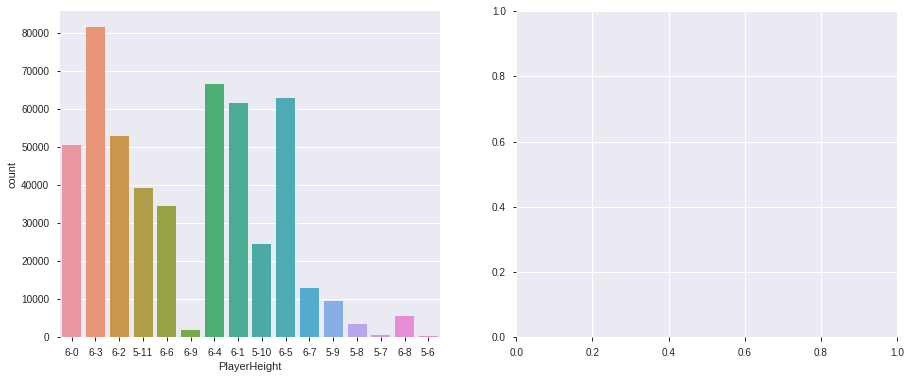

In [44]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(train_df["PlayerHeight"])
plt.subplot(1,2,2)
sns.countplot(test_df["PlayerHeight"])

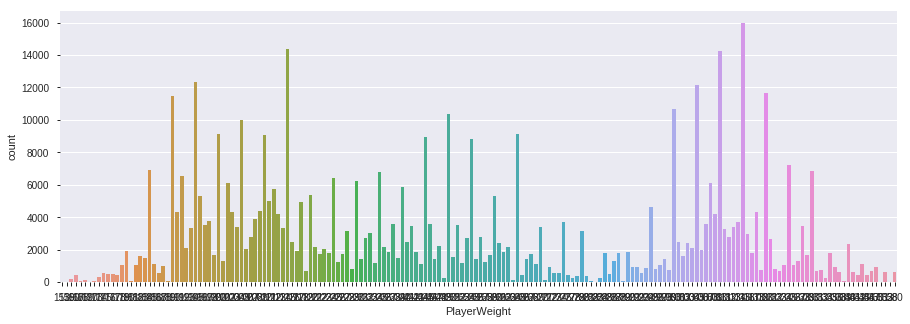

In [45]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["PlayerWeight"])

In [46]:
print(train_df["PlayerCollegeName"].value_counts())

Alabama            16174
Ohio State         13984
Louisiana State    12211
Florida            11775
Georgia            11686
                   ...  
Cal Poly               3
Texas Southern         3
Eastern Oregon         2
Stetson                2
Alcorn State           1
Name: PlayerCollegeName, Length: 301, dtype: int64


In [47]:
print(train_df["Position"].value_counts())

CB     56686
WR     53325
G      42114
T      42046
DE     35890
DT     35637
OLB    34110
TE     33237
FS     24607
C      24062
RB     23908
QB     23290
SS     20540
ILB    18541
MLB    10208
NT      8226
LB      6699
OT      6097
FB      3211
OG      3073
DB      1931
S       1641
HB       647
SAF       19
DL        17
Name: Position, dtype: int64


In [48]:
print(train_df["HomeTeamAbbr"].value_counts())
print("team no: ", len(train_df["HomeTeamAbbr"].unique()))

SF     17402
NYG    17336
NE     17248
BUF    17204
BAL    17094
SEA    16962
CIN    16588
IND    16544
DEN    16478
OAK    16456
ARI    16434
NYJ    16236
MIN    16170
JAX    15972
DAL    15950
CLE    15928
HOU    15884
TEN    15862
LA     15642
NO     15554
LAC    15532
MIA    15400
WAS    15356
CHI    15334
KC     15334
GB     15312
DET    15246
ATL    15246
PIT    14850
TB     14696
PHI    14476
CAR    14036
Name: HomeTeamAbbr, dtype: int64
team no:  32


In [49]:
print(train_df["VisitorTeamAbbr"].value_counts())
print("team no: ", len(train_df["VisitorTeamAbbr"].unique()))

LA     17864
JAX    17072
IND    16764
LAC    16720
DEN    16698
OAK    16478
TEN    16478
NYJ    16390
WAS    16390
DET    16368
ARI    16302
SF     16302
MIA    16236
HOU    16170
CHI    16038
NO     16038
KC     15862
DAL    15840
BAL    15818
MIN    15774
SEA    15774
CIN    15708
BUF    15664
NE     15510
CLE    15422
TB     15378
NYG    15356
GB     15312
PIT    15114
ATL    15092
PHI    14168
CAR    13662
Name: VisitorTeamAbbr, dtype: int64
team no:  32


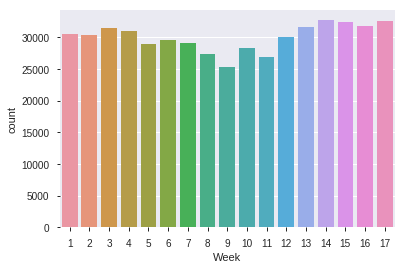

In [50]:
sns.countplot(train_df["Week"])

In [51]:
print(train_df["Stadium"].value_counts())

MetLife Stadium                        21054
Levis Stadium                          17402
Gillette Stadium                       17248
New Era Field                          17204
Lucas Oil Stadium                      16544
U.S. Bank Stadium                      16170
AT&T Stadium                           15950
Nissan Stadium                         15862
Mercedes-Benz Superdome                15554
Paul Brown Stadium                     15444
FedExField                             15356
Soldier Field                          15334
Arrowhead Stadium                      15334
Ford Field                             15246
Heinz Field                            14850
Raymond James Stadium                  14696
StubHub Center                         14630
CenturyLink Field                      14586
Hard Rock Stadium                      14564
Lincoln Financial Field                14476
Mercedes-Benz Stadium                  14388
Lambeau Field                          14300
Bank of Am

In [52]:
print("only 2018:", set(train_2018[train_2018.columns[40]].unique()) - set(train_2017[train_2017.columns[40]].unique()))
print("only 2017:", set(train_2017[train_2017.columns[40]].unique()) - set(train_2018[train_2018.columns[40]].unique()))

NameError: name 'train_2018' is not defined

In [53]:
print(train_df["Location"].value_counts())

East Rutherford, NJ          30096
Santa Clara, CA              17402
Indianapolis, Ind.           16544
Denver, CO                   16478
Glendale, AZ                 16434
Minneapolis, MN              16170
Baltimore, Md.               16016
Nashville, TN                15862
Orchard Park NY              15488
Landover, MD                 15356
Green Bay, WI                15312
Atlanta, GA                  15246
Arlington, Texas             15246
Foxborough, MA               15224
Tampa, FL                    14696
Seattle, WA                  14630
Carson, CA                   14630
Oakland, CA                  14564
Chicago, IL                  14498
Cincinnati, Ohio             14476
Kansas City, MO              14190
Los Angeles, Calif.          13706
Miami Gardens, Fla.          13486
Pittsburgh                   13178
Philadelphia, Pa.            13156
Jacksonville, FL             11352
New Orleans, LA              11110
Detroit                      10670
Houston, TX         

In [54]:
print(train_df["StadiumType"].value_counts())

Outdoor                   267696
Outdoors                   67474
Indoors                    40854
Dome                       17336
Indoor                     16148
Retractable Roof           15884
Open                        9614
Retr. Roof-Closed           7172
Retr. Roof - Closed         6446
Domed, closed               5918
Domed, open                 2684
Closed Dome                 2134
Dome, closed                1826
Domed                       1826
Oudoor                      1188
Retr. Roof Closed           1056
Indoor, Roof Closed         1056
Retr. Roof-Open              990
Bowl                         968
Outddors                     968
Heinz Field                  902
Retr. Roof - Open            880
Outdoor Retr Roof-Open       880
Outdor                       858
Indoor, Open Roof            858
Ourdoor                      858
Outside                      814
Domed, Open                  770
Cloudy                       770
Name: StadiumType, dtype: int64


In [55]:
# print(train_df["Turf"].value_counts())
grass_labels = ['grass', 'natural grass', 'natural', 'naturall grass']
train_df['Turf'] = np.where(train_df.Turf.str.lower().isin(grass_labels), "Natural", "Artificial")

In [56]:
#print(train_df["GameWeather"].unique())
top20_wether = list(train_df.GameWeather.value_counts(normalize=True, dropna=False).cumsum().head(20).index)

In [57]:
sns.distplot(train_2017["Temperature"].dropna())
sns.distplot(train_2018["Temperature"].dropna())

NameError: name 'train_2017' is not defined

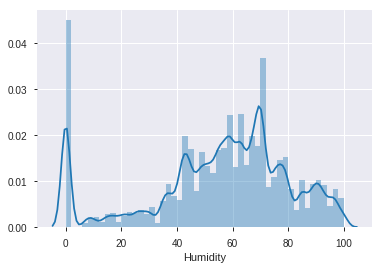

In [58]:
sns.distplot(train_df["Humidity"].dropna())

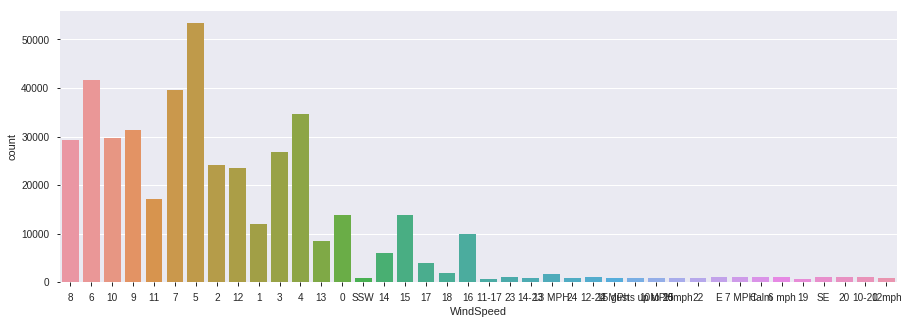

In [59]:
plt.figure(figsize=(15,5))
sns.countplot(train_df["WindSpeed"].dropna())

In [60]:
#train_df["WindDirection"].value_counts()
train_df.WindDirection.value_counts(normalize=True, dropna=False).cumsum().head(30)

NaN          0.157395
NE           0.216736
NW           0.270165
SW           0.320832
SE           0.371413
WSW          0.418929
N            0.464417
W            0.507963
S            0.549912
NNE          0.589918
South        0.629796
SSW          0.668853
WNW          0.706357
North        0.740063
NNW          0.767597
West         0.794312
SSE          0.820552
E            0.845712
ENE          0.866903
ESE          0.886280
East         0.900695
Northwest    0.908679
From SW      0.916275
Northeast    0.923439
NorthEast    0.929740
From S       0.935911
s            0.941263
SouthWest    0.945449
Southeast    0.949247
W-NW         0.952786
Name: WindDirection, dtype: float64

# multivariate analysis

## Correlation

In [61]:
# correlations of all variables
unused_columns = ["GameId","PlayId","NflId", "TimeHandoff","TimeSnap", "Location"]
check_columns = [i for i in train_df.columns if i not in unused_columns]
category_change = [i for i in train_df.columns if train_df[i].dtype=='object' and i not in unused_columns]
ce_oe = ce.OrdinalEncoder(cols=category_change, handle_unknown="impute")
train_df = ce_oe.fit_transform(train_df)
correlations = train_df[check_columns].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
corr_columns = ["level_0", "level_1", "value"]
correlations.columns = corr_columns
correlations = correlations.sort_values("value", ascending=False)
correlations.head(30)

,level_0,level_1,value
1805,Dis,S,0.930024
1804,S,Dis,0.930024
1803,DisplayName,PlayerBirthDate,0.851705
1802,PlayerBirthDate,DisplayName,0.851705
1801,JerseyNumber,PlayerWeight,0.739988
1800,PlayerWeight,JerseyNumber,0.739988
1799,HomeTeamAbbr,Stadium,0.709305
1798,Stadium,HomeTeamAbbr,0.709305
1797,HomeScoreBeforePlay,Quarter,0.669133
1796,Quarter,HomeScoreBeforePlay,0.669133


In [62]:
# especially high correlations
high_corr = correlations[correlations["value"]>=0.8]
remove_index = []
for i in range(high_corr.shape[0]-1):
    for j in range(i+1, high_corr.shape[0]):
        if high_corr.iloc[i]["level_0"] == high_corr.iloc[j]["level_1"] and high_corr.iloc[i]["level_1"] == high_corr.iloc[j]["level_0"]:
            remove_index.append(j)
            break
select_index = [i for i in range(high_corr.shape[0]) if i not in remove_index]
high_corr_no_duplicate = high_corr.iloc[select_index].reset_index(drop=True)
high_corr_no_duplicate

,level_0,level_1,value
0,Dis,S,0.930024
1,DisplayName,PlayerBirthDate,0.851705


In [63]:
# correlation between target and input variables
obj_correlations = correlations[correlations['level_0'] =="Yards"].sort_values("value", ascending=False).reset_index(drop=True)
np.transpose(obj_correlations)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
level_0,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards,Yards
level_1,DefendersInTheBox,Distance,YardLine,Season,OffensePersonnel,OffenseFormation,A,Down,NflIdRusher,StadiumType,Temperature,WindSpeed,PossessionTeam,WindDirection,DisplayName,VisitorTeamAbbr,PlayerBirthDate,VisitorScoreBeforePlay,PlayerWeight,DefensePersonnel,JerseyNumber,Quarter,HomeScoreBeforePlay,Humidity,GameWeather,GameClock,HomeTeamAbbr,Week,Turf,PlayerHeight,PlayDirection,S,Position,Orientation,Stadium,X,Dir,Dis,Y,PlayerCollegeName,FieldPosition,Team
value,0.109212,0.0719364,0.0645513,0.0313499,0.027488,0.0261428,0.0225919,0.0216725,0.0189973,0.0124027,0.0123671,0.0116292,0.0109653,0.010824,0.00967641,0.00961973,0.00917021,0.00908398,0.00886179,0.00850694,0.00803833,0.00673313,0.00470593,0.00390052,0.00346332,0.00340924,0.00340245,0.00326473,0.00312222,0.00294452,0.00235793,0.00132751,0.0011294,0.00103377,0.0008502,0.000740887,0.000483461,0.000310282,0.000281421,0.000111316,5.37139e-05,6.27021e-18


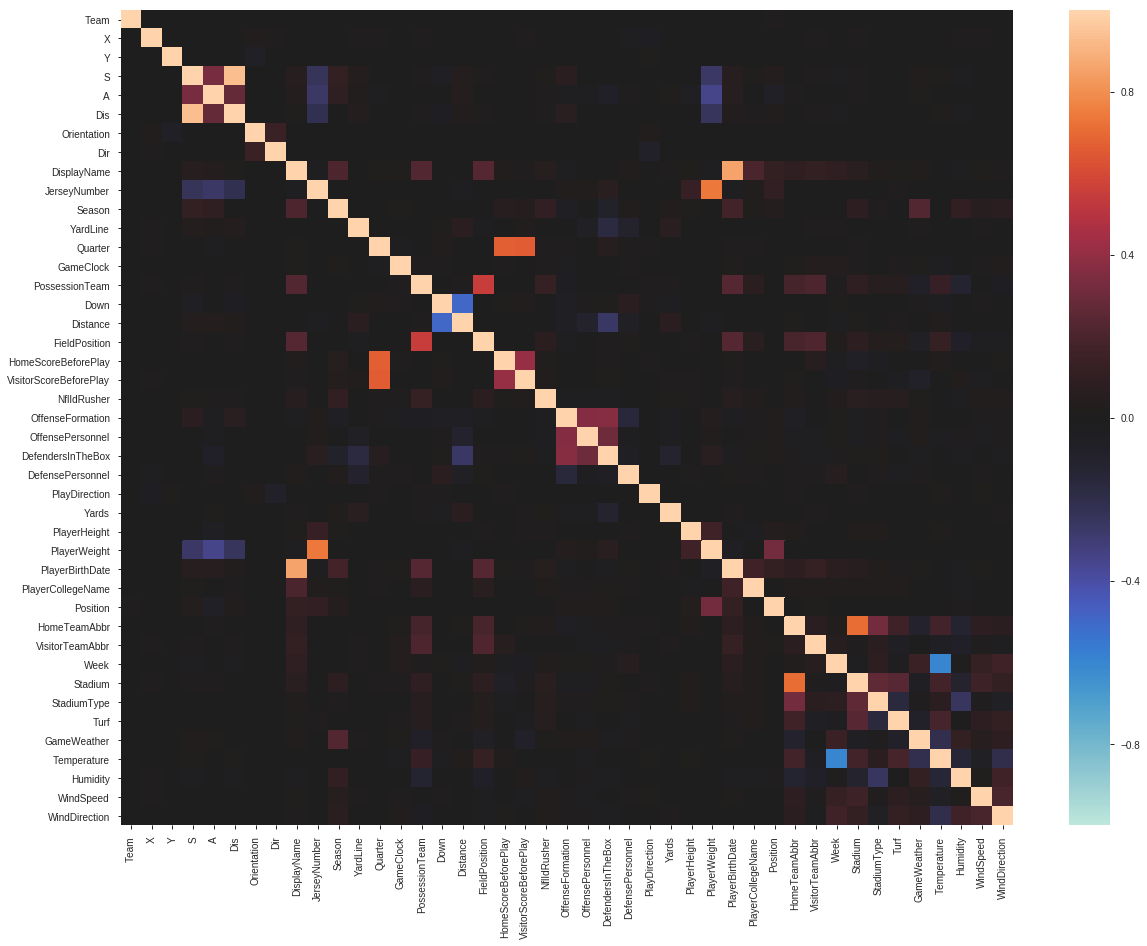

In [64]:
# heatmap
plt.figure(figsize=(20,15))
sns.heatmap(train_df[check_columns].corr(), vmax=1, vmin=-1, center=0)

## plot between yards(target) and other input variables

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0.5, 1.0, 'nan')

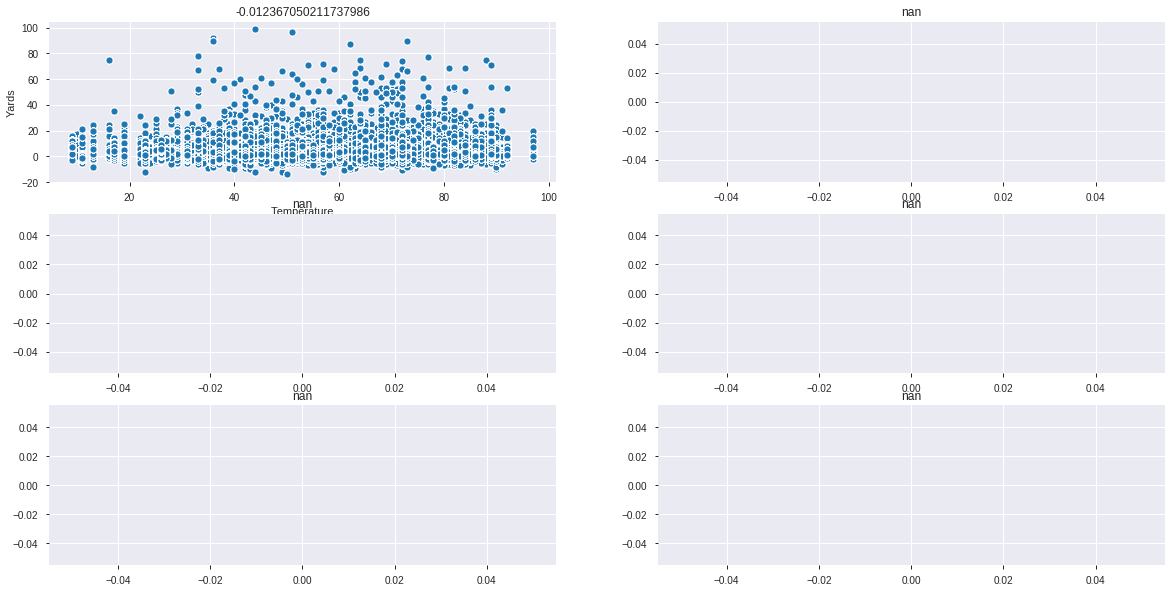

In [65]:
# yards vs stadiumtype and temperature
check_columns = ["Yards", "Temperature"]
outdoor_train = train_df[train_df.StadiumType == "outdoor"]
indooropen_train = train_df[train_df.StadiumType == "indoor open"]
indoorclose_train = train_df[train_df.StadiumType == "indoor closed"]
domeopen_train = train_df[train_df.StadiumType == "dome_closed"]
domeclose_train = train_df[train_df.StadiumType == "dome_open"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["Temperature"], train_df["Yards"])
plt.title(train_df[check_columns].corr().iloc[0,1])
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["Temperature"], outdoor_train["Yards"])
plt.title(outdoor_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["Temperature"], indooropen_train["Yards"])
plt.title(indooropen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["Temperature"], indoorclose_train["Yards"])
plt.title(indoorclose_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["Temperature"], domeopen_train["Yards"])
plt.title(domeopen_train[check_columns].corr().iloc[0,1])
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["Temperature"], domeclose_train["Yards"])
plt.title(domeclose_train[check_columns].corr().iloc[0,1])

Text(0.5, 1.0, 'domeclose')

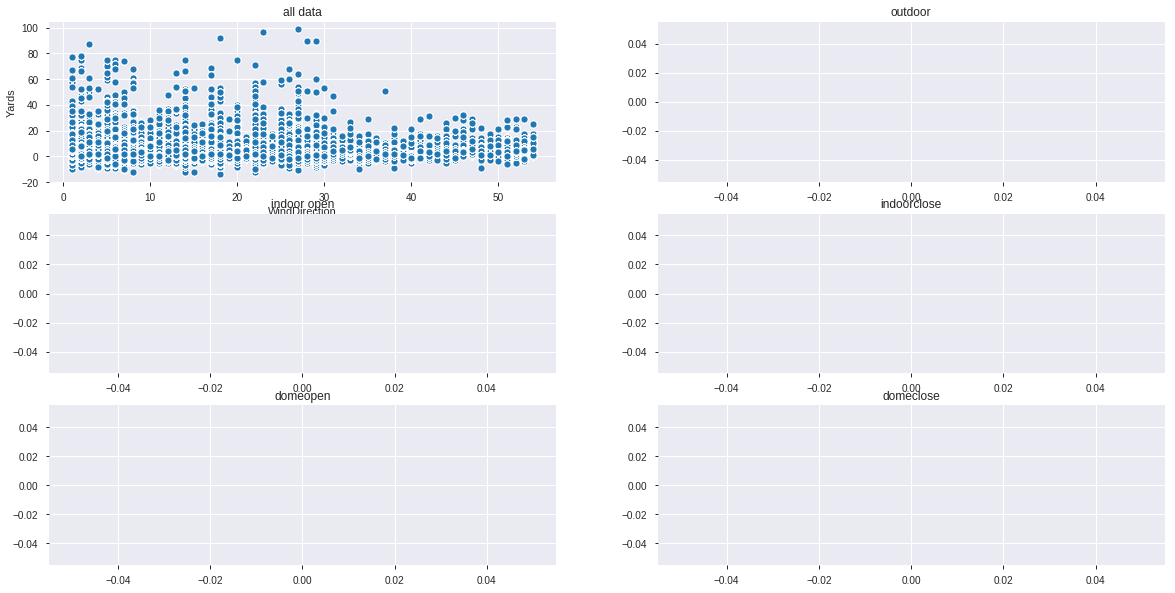

In [66]:
# yards vs stadiumtype and winddirection
check_columns = ["Yards", "WindDirection"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindDirection"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindDirection"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindDirection"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindDirection"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindDirection"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindDirection"], domeclose_train["Yards"])
plt.title("domeclose")

Text(0.5, 1.0, 'domeclose')

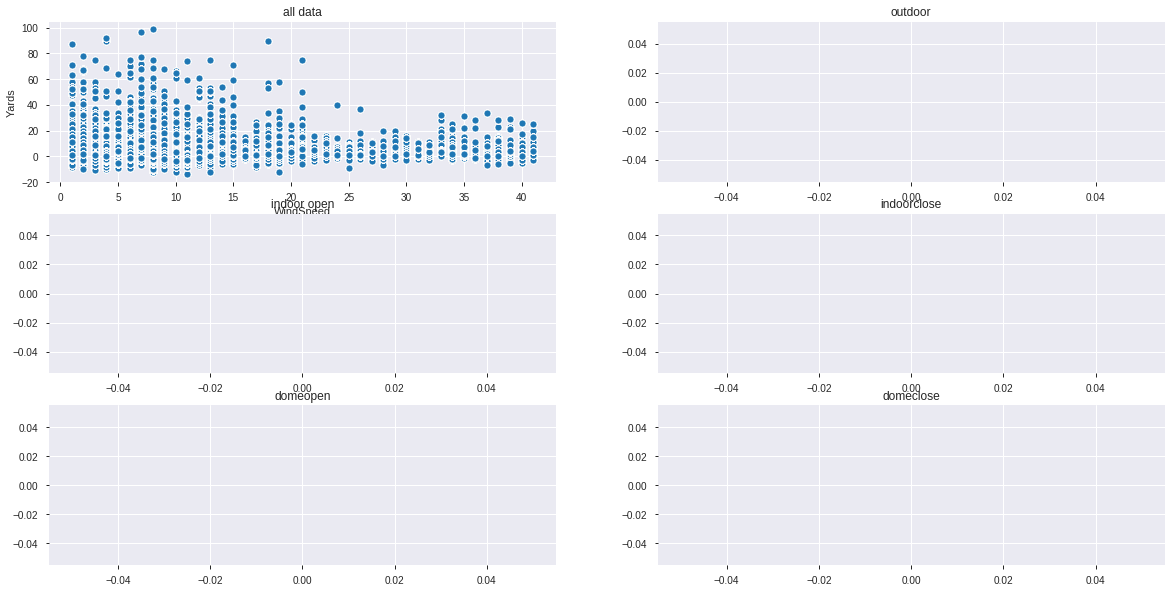

In [67]:
# yards vs stadiumtype and windspeed
check_columns = ["Yards", "WindSpeed"]
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
sns.scatterplot(train_df["WindSpeed"], train_df["Yards"])
plt.title("all data")
plt.subplot(3,2,2)
sns.scatterplot(outdoor_train["WindSpeed"], outdoor_train["Yards"])
plt.title("outdoor")
plt.subplot(3,2,3)
sns.scatterplot(indooropen_train["WindSpeed"], indooropen_train["Yards"])
plt.title("indoor open")
plt.subplot(3,2,4)
sns.scatterplot(indoorclose_train["WindSpeed"], indoorclose_train["Yards"])
plt.title("indoorclose")
plt.subplot(3,2,5)
sns.scatterplot(domeopen_train["WindSpeed"], domeopen_train["Yards"])
plt.title("domeopen")
plt.subplot(3,2,6)
sns.scatterplot(domeclose_train["WindSpeed"], domeclose_train["Yards"])
plt.title("domeclose")

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


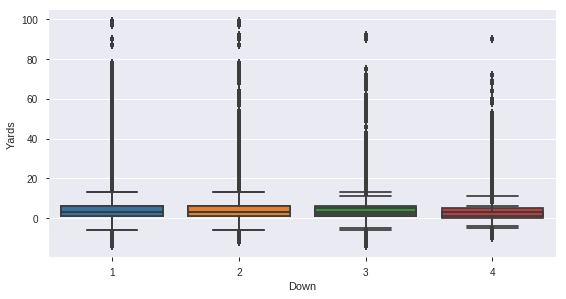

In [68]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sns.boxplot(train_df["Quarter"], train_df["Yards"])
plt.subplot(2,2,1)
sns.boxplot(train_df["Down"], train_df["Yards"])

In [69]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Quarter", aggfunc="mean")

Quarter,1,2,3,4,5
Down,,,,,
1,4.229977,4.519133,4.391578,4.052392,4.728972
2,4.064176,4.231695,4.355049,3.881786,5.040000
3,3.820375,4.087607,4.470032,4.078003,3.533333
4,3.000000,1.755102,3.303030,1.548387,1.000000


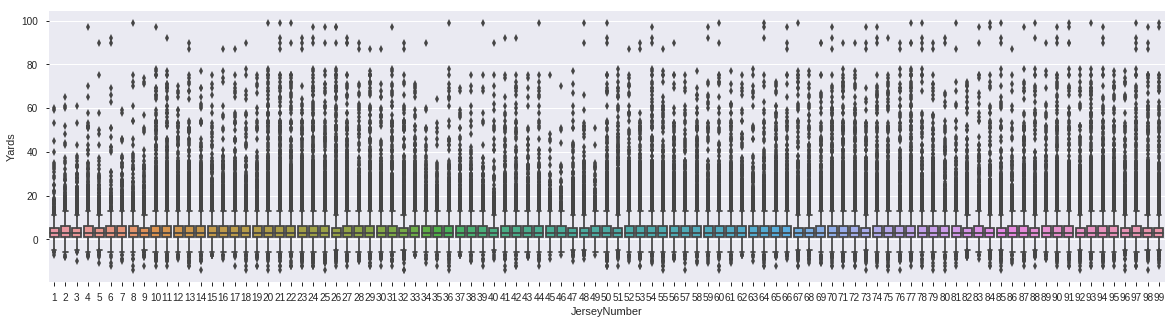

In [70]:
plt.figure(figsize=(20,5)) 
sns.boxplot(train_df["JerseyNumber"], train_df["Yards"])

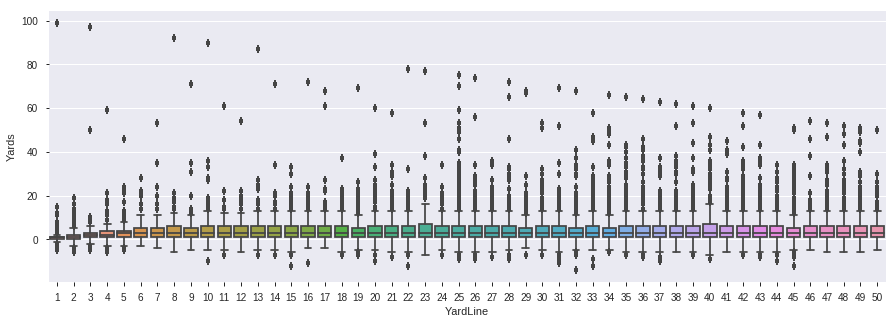

In [71]:
plt.figure(figsize=(15,5)) # clearly different
sns.boxplot(train_df["YardLine"], train_df["Yards"])

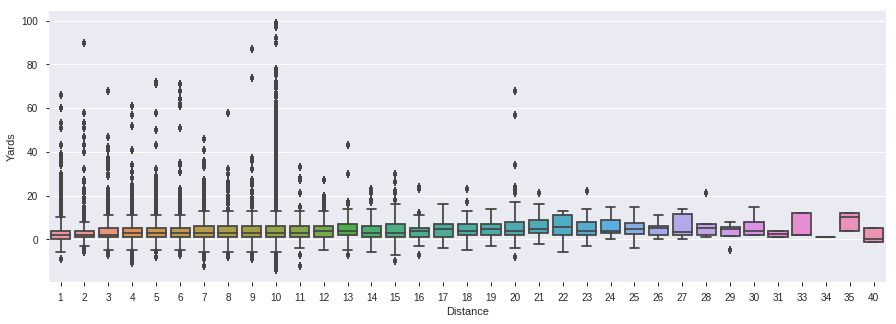

In [72]:
# Distance vs yards
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Distance"], train_df["Yards"])

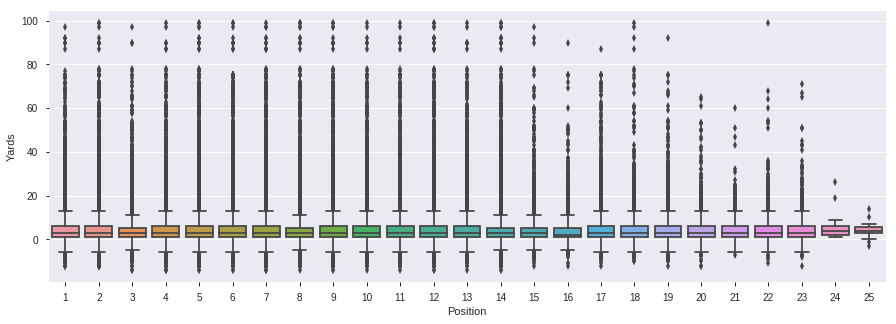

In [73]:
plt.figure(figsize=(15,5))
sns.boxplot(train_df["Position"], train_df["Yards"])

In [74]:
pd.pivot_table(train_df, values="Yards", index="Down", columns="Distance", aggfunc="mean")

Distance,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,35,40
Down,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.297753,0.562500,1.445946,1.578313,2.993750,2.743902,2.876543,3.295918,3.217391,4.468340,4.500000,5.000000,5.714286,6.750000,4.503876,1.625000,3.875000,3.666667,3.090909,5.110236,NaN,NaN,4.000000,5.0,3.333333,NaN,3.000000,NaN,NaN,4.666667,NaN,2.0,NaN,12.0,2.5
2,3.248991,3.604356,3.954939,3.807512,4.499276,4.129630,3.855049,4.019298,4.501075,4.721472,3.520710,4.212121,4.661972,3.431034,3.866667,4.642857,3.542857,4.931034,4.733333,6.571429,6.769231,6.454545,3.818182,4.0,5.545455,5.666667,5.666667,12.5,6.5,NaN,NaN,2.0,1.0,NaN,-1.0
3,3.373626,3.774809,5.000000,5.222222,5.322034,3.528302,4.191489,5.000000,4.972222,2.775510,4.448276,6.600000,4.807692,4.470588,7.733333,4.352941,6.200000,4.892857,6.307692,12.000000,5.111111,5.222222,9.000000,7.0,9.000000,3.750000,7.250000,4.0,-0.5,8.500000,2.5,12.0,NaN,7.0,NaN
4,2.029940,2.818182,5.250000,2.000000,6.000000,NaN,NaN,-3.000000,NaN,8.333333,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
pd.pivot_table(train_df, values="Yards", index="Dis", columns="Position", aggfunc="mean")

Position,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Dis,,,,,,,,,,,,,,,,,,,,,,,,,
0.00,4.137931,3.674699,3.756757,4.140000,4.343195,4.221649,3.603774,4.821053,4.517241,4.441786,3.545455,3.772222,3.543353,4.105882,4.153846,2.0,6.363636,0.666667,3.190476,3.000000,NaN,3.000000,4.000000,NaN,NaN
0.01,4.613900,4.753363,5.045977,3.688022,4.647189,4.224622,3.909483,4.198953,4.297003,4.235838,4.138889,4.363636,4.462236,4.108597,3.175926,2.5,4.865854,4.812500,5.722222,5.687500,NaN,6.000000,4.166667,NaN,NaN
0.02,4.100592,4.324561,5.766667,3.765217,4.457627,3.952000,4.256881,4.324138,4.073171,4.702614,3.250000,3.540230,5.139738,4.948718,4.145833,0.5,5.093750,4.736842,4.031250,5.954545,-4.0,7.058824,7.600000,NaN,5.0
0.03,4.366492,3.980831,4.348315,3.944853,4.531128,3.893967,3.891089,3.885000,4.139651,4.461268,2.562500,3.918519,3.953069,4.053191,3.540146,NaN,6.431818,3.333333,4.666667,3.258065,NaN,2.000000,6.941176,NaN,NaN
0.04,4.475610,4.258953,4.130435,4.271293,4.880911,3.877850,3.226804,3.748387,3.897177,4.334395,5.166667,4.492784,4.362434,4.607930,4.475610,2.5,3.918367,4.363636,2.755102,2.300000,9.0,3.434783,2.812500,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.10,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.13,NaN,NaN,NaN,NaN,NaN,NaN,7.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.16,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


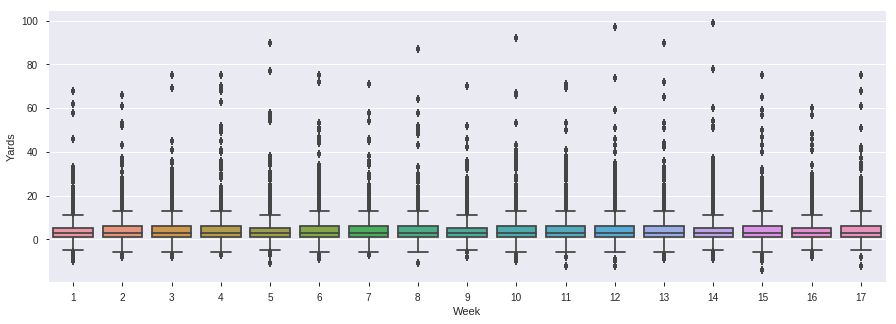

In [76]:
# week vs yards (seems to have no correlation)
plt.figure(figsize=(15,5)) 
sns.boxplot(train_df["Week"], train_df["Yards"])

## plot between input variables

In [77]:
sns.distplot((train_df[train_df.OnOffense==True]["Orientation_std_mod"]).dropna())

AttributeError: 'DataFrame' object has no attribute 'OnOffense'

In [78]:
sns.distplot((train_df[train_df.OnOffense==True]["Dir_std_mod"]).dropna())

AttributeError: 'DataFrame' object has no attribute 'OnOffense'

In [79]:
sns.distplot((train_df[train_df.OnOffense==False]["Orientation_std_mod"]).dropna())

AttributeError: 'DataFrame' object has no attribute 'OnOffense'

In [80]:
sns.distplot((train_df[train_df.OnOffense==False]["Dir_std_mod"]).dropna())

AttributeError: 'DataFrame' object has no attribute 'OnOffense'

In [81]:
sns.distplot((train_df["Orientation_std_mod"]- train_df["Dir_std_mod"]).dropna())

KeyError: 'Orientation_std_mod'

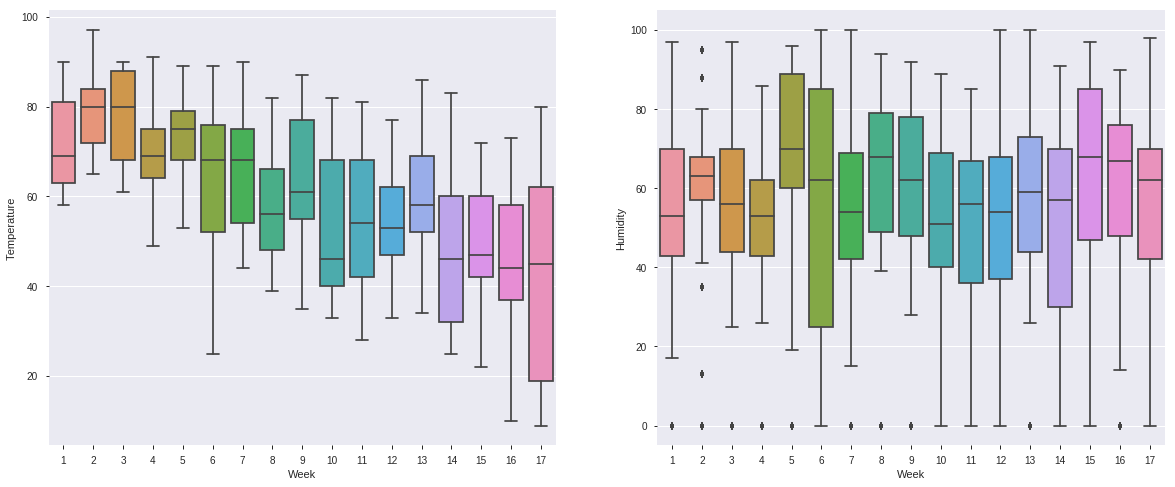

In [82]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(train_df["Week"], train_df["Temperature"])
plt.subplot(1,2,2)
sns.boxplot(train_df["Week"], train_df["Humidity"])

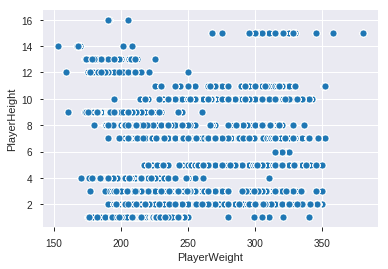

In [83]:
sns.scatterplot(train_df["PlayerWeight"], train_df["PlayerHeight"])

Home win   :  229416
Visitor win:  166034
Tie game   :  114312


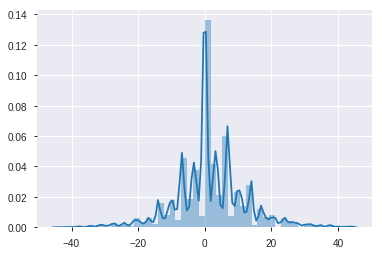

In [84]:
# score difference: almost the same, but more opportunities when home team lead the opponent
score_diff = train_df[train_df.columns[21]] - train_df[train_df.columns[22]]
print("Home win   : ", len(score_diff[score_diff > 0]))
print("Visitor win: ", len(score_diff[score_diff < 0]))
print("Tie game   : ", len(score_diff[score_diff == 0]))
sns.distplot(score_diff)

In [85]:
train_df[train_df.OnOffense == True]["Position"].value_counts() #QBは攻撃の要のはずだが、一プレイに一人いるわけではなさそう

AttributeError: 'DataFrame' object has no attribute 'OnOffense'

In [86]:
# threre's no QB in defense team, however, some offense teams include more than one QB in the team
#set(train["PlayId"].unique()) - set(train[(train.Position=="QB") | (train.Position=="C")]["PlayId"].unique()) # no diff
#set(train["PlayId"].unique()) - set(train[train.Position=="QB"]["PlayId"].unique()) # 2 cases when no QB plays

# Player position plot by each play and how to standardize X, Y, Orientation, Dir and Yardline

In [87]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)
        
    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line: # display scrimmage line
        hl = highlight_line_number
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

ValueError: scatter requires x column to be numeric

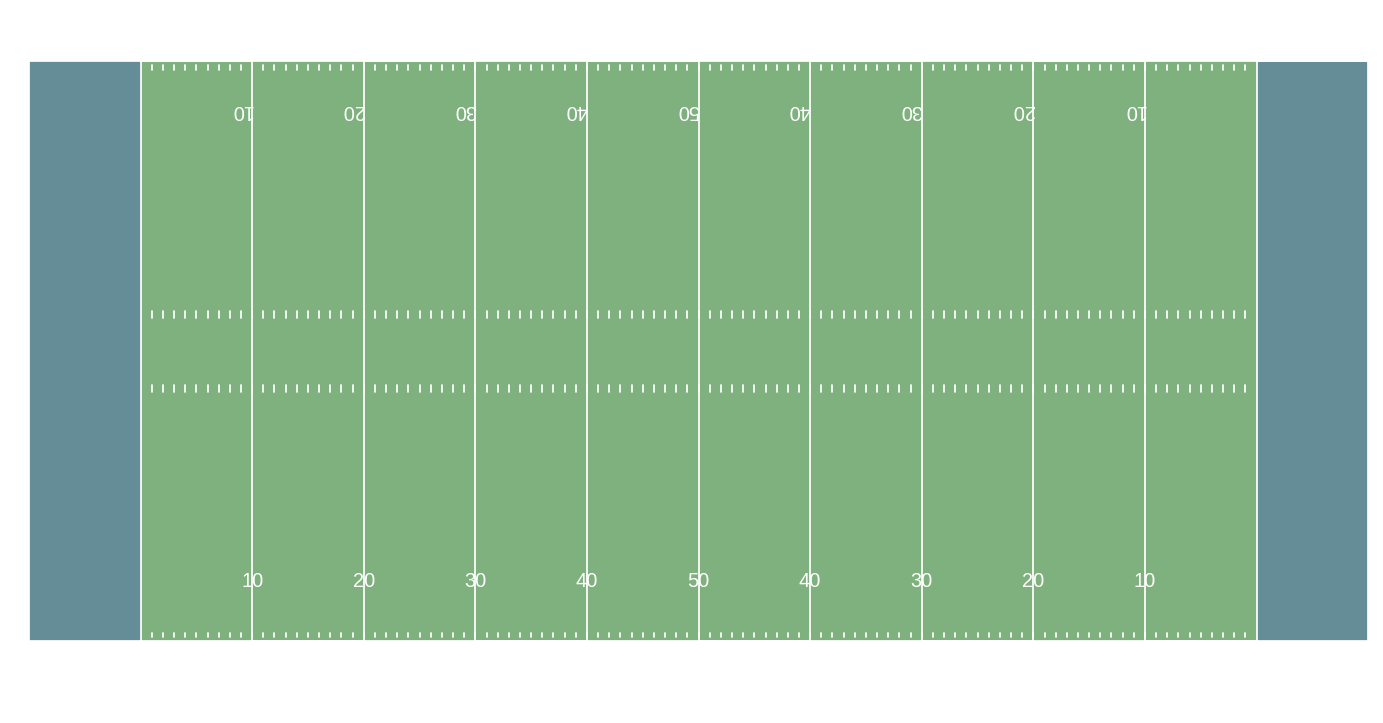

In [88]:
# from https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-nfl :code
# from https://www.kaggle.com/ben519/understanding-x-y-dir-and-orientation :validate angle of dir
def get_dx_dy(angle, dist):
    cartesianAngleRadians = (450-angle)*math.pi/180.0 #confirm that this formulation is correct, but how did they find it?
    dx = dist * math.cos(cartesianAngleRadians)
    dy = dist * math.sin(cartesianAngleRadians)
    return dx, dy

play_id = 20181111022155 #20181126001222 #20181206001238 #20181007011551 #
fig, ax = create_football_field()
train_df.query("PlayId == @play_id and Team == 'away'") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=50, legend='Away')
train_df.query("PlayId == @play_id and Team == 'home'") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=50, legend='Home')
train_df.query("PlayId == @play_id and NflIdRusher == NflId") \
    .plot(x='X', y='Y', kind='scatter', ax=ax, color='red', s=100, legend='Rusher')
rusher_row = train_df.query("PlayId == @play_id and NflIdRusher == NflId")
yards_covered = rusher_row["Yards"].values[0]
original_dir = rusher_row["Dir"].values[0]
playdirection = rusher_row["PlayDirection"].values[0]

x = rusher_row["X"].values[0]
y = rusher_row["Y"].values[0]
rusher_dir = rusher_row["Dir"].values[0]
rusher_speed = rusher_row["S"].values[0]
dx, dy = get_dx_dy(rusher_dir, rusher_speed)

ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color="black")
plt.title(f'Play # {play_id} and yard distance is {yards_covered} and dir is {original_dir} {playdirection}', fontsize=20)
plt.legend()
plt.show()

ValueError: scatter requires x column to be numeric

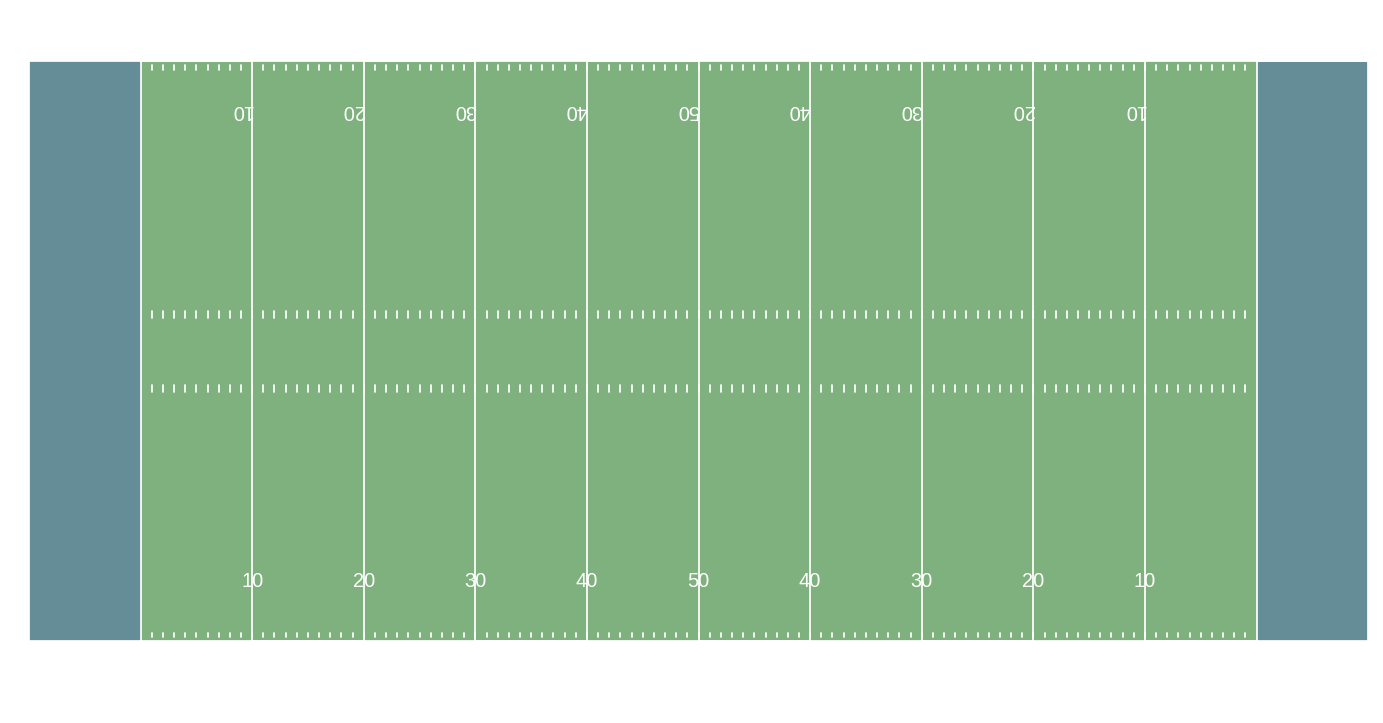

In [89]:
# standardization 1: confirm that this standardization is correct
train_df['ToLeft'] = train_df.PlayDirection == "left"
train_df['TeamOnOffense'] = "home"
train_df.loc[train_df.PossessionTeam != train_df.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train_df['OnOffense'] = train_df.Team == train_df.TeamOnOffense # Is player on offense?
train_df['YardLine_std'] = 100 - train_df.YardLine.copy()
train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
            'YardLine_std'
             ] = train_df.loc[train_df.FieldPosition.fillna('') == train_df.PossessionTeam,  
              'YardLine']
train_df['X_std'] = train_df.X.copy()
train_df.loc[train_df.ToLeft, 'X_std'] = 120 - train_df.loc[train_df.ToLeft, 'X'] 
train_df['Y_std'] = train_df.Y.copy()
train_df.loc[train_df.ToLeft, 'Y_std'] = 53.3 - train_df.loc[train_df.ToLeft, 'Y'] 
train_df.loc[train_df['Season'] == 2017, 'Orientation'] = np.mod(90 + train_df.loc[train_df['Season'] == 2017, 'Orientation'], 360) 
train_df['Orientation_std'] = train_df.Orientation.copy()
train_df.loc[train_df.ToLeft, 'Orientation_std'] = np.mod(180 + train_df.loc[train_df.ToLeft, 'Orientation_std'], 360)
train_df['Dir_std'] = train_df.Dir.copy() # to deal with direction change, not cos, sin 
train_df.loc[train_df.ToLeft, 'Dir_std'] = np.mod(180 + train_df.loc[train_df.ToLeft, 'Dir_std'], 360)
#train.drop(["X", "Y", "Orientation", "YardLine", "Dir", "ToLeft"], axis=1, inplace=True)
#train.rename(columns={'X_std': 'X', 'Y_std': 'Y', 'Orientation_std': 'Orientation', 'Dir_std': 'Dir', "YardLine_std": "YardLine"}, inplace=True)

play_id = 20181111022155 # 20181126001222 #20181206001238 #20181007011551 
fig, ax = create_football_field()
train_df.query("PlayId == @play_id and Team == 'away'") \
    .plot(x='X_std', y='Y_std', kind='scatter', ax=ax, color='orange', s=50, legend='Away')
train_df.query("PlayId == @play_id and Team == 'home'") \
    .plot(x='X_std', y='Y_std', kind='scatter', ax=ax, color='blue', s=50, legend='Home')
train_df.query("PlayId == @play_id and NflIdRusher == NflId") \
    .plot(x='X_std', y='Y_std', kind='scatter', ax=ax, color='red', s=100, legend='Rusher')
rusher_row = train_df.query("PlayId == @play_id and NflIdRusher == NflId")
yards_covered = rusher_row["Yards"].values[0]
dire = rusher_row["Dir_std"].values[0]
playdirection = rusher_row["PlayDirection"].values[0]
yardline = rusher_row['YardLine_std'].values[0] + 10
orientation = rusher_row["Orientation_std"].values[0]
odx, ody = get_dx_dy(orientation, rusher_speed)

x = rusher_row["X_std"].values[0]
y = rusher_row["Y_std"].values[0]
rusher_dir = rusher_row["Dir_std"].values[0]
rusher_speed = rusher_row["S"].values[0]
dx, dy = get_dx_dy(rusher_dir, rusher_speed)
print(dx, dy)
ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.3, color="black")
ax.arrow(x, y, odx, ody, length_includes_head=True, width=0.3, color="pink")
plt.title(f'Play # {play_id} and yard distance is {yards_covered} and dir is {dire} {playdirection}', fontsize=20)
plt.axvline(yardline)
plt.legend()
plt.show()

# voronoi area
Certainly, the area of voronoi regions affect the prediction quality, so I want to implement calculations of voronoi regions. However, when the area of voronoi region becomes infinity, additional processes are necessary.

In [90]:
def voronoi_plot(points, rusher_index):
    v = Voronoi(points)
    for i, reg_num in enumerate(v.point_region):
        if reg_num == v.point_region[rusher_index]:
            index = i
            rusher_reg_num = reg_num
    # plot voronoi region -----------------------------
    #fig = plt.figure(figsize=(10,5))
    voronoi_plot_2d(v, show_vertices=False)
    #ax = fig.add_subplot(1,1,1)
    #ax.set_xlim(0,120)
    #ax.set_ylim(0,53.3)
    for region in v.regions: # color for only rusher
        if v.regions[rusher_reg_num] == region:
            polygon = [v.vertices[i] for i in region]
            plt.fill(*zip(*polygon), c="orange")
    # plot voronoi region ----------------------------- 

In [91]:
def voronoi_volumes(points, rusher_index): # function to calculate voronoi area
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    
    #print("points:", points)
    #print(v.point_region) # index of voronoi region for each input point
    #print(v.regions) # voronoi points in each voronoi region
    for i, reg_num in enumerate(v.point_region):
        #print("i, reg_num:", (i, reg_num))
        indices = v.regions[reg_num]
        #print("regions:", indices)
        if -1 in indices: # some regions can be opened
            vol[i] = np.nan ## insert missing value when the area is open
            #print(v.vertices[indices])
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
        
        if reg_num == v.point_region[rusher_index]:
            #print("this is the voronoi area of rusher: ", vol[i])
            index = i
            rusher_reg_num = reg_num         
        
    return vol[index]

# calculate voronoi regions (sample) ----------------------------------
#pts = np.array(train_df.iloc[0:22][["X", "Y"]])
#tmp_df = train_df.iloc[0:22][["X", "Y", "IsRusher"]]
#rusher_index = tmp_df[tmp_df.IsRusher==True].index[0]
#voronoi_volumes(pts, rusher_index)
# --------------------------------------------------------------------

pts = np.array(train_df[["X", "Y"]]).reshape(train_df.shape[0]//22, 22, 2) # plays * players * (X, Y, rusher)
# index of row where rusher data is included when separated by each play
rusher_index = list(train_df[train_df.IsRusher==True].index % 22) 
rusher_voronoi = []
for i in tqdm.tqdm(range(0, train_df.shape[0] //22)):
    rusher_voronoi.append(voronoi_volumes(pts[i], rusher_index[i]))

AttributeError: 'DataFrame' object has no attribute 'IsRusher'

# validation split

In [92]:
from sklearn.model_selection import KFold # some future data is included in the training data when we check the model performance in the validation data
kf=KFold(n_splits = 5, random_state=1108)
X_train = train_df.copy()
#X_train.sort_values(["GameId", "PlayId"], inplace=True)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print("fold:", i+1)
    #X_train2= X_train.iloc[train_index,:]
    #y_train2= y_train.iloc[train_index]
    training_data = X_train.iloc[train_index, :]
    # validation data
    X_test2= X_train.iloc[test_index,:].drop("Yards", axis=1)
    y_test2= X_train.iloc[test_index]["Yards"]
    print(X_test2["GameId"].unique())
    test_first_gameid = min(X_test2["GameId"].unique())
    final_train_gameid = []
    for i in list(training_data["GameId"].unique()):
        if i < test_first_gameid:
            final_train_gameid.append(i)
    #print(final_train_gameid)
    if len(final_train_gameid) > len(X_test2["GameId"].unique()):
        final_training_data = training_data[training_data.GameId.isin(final_train_gameid)].reset_index(drop=True)
        X_train2 = final_training_data.drop("Yards", axis=1)
        y_train2 = final_training_data["Yards"]
        #print(X_train2.shape[0])
        #print(X_test2.shape[0])
    else:
        continue

fold: 1
[2017090700 2017091000 2017091001 2017091002 2017091003 2017091004
 2017091005 2017091007 2017091008 2017091009 2017091010 2017091011
 2017091012 2017091100 2017091101 2017091400 2017091700 2017091701
 2017091702 2017091703 2017091704 2017091705 2017091706 2017091707
 2017091708 2017091709 2017091710 2017091711 2017091712 2017091713
 2017091800 2017092100 2017092400 2017092401 2017092402 2017092403
 2017092404 2017092405 2017092406 2017092407 2017092408 2017092409
 2017092410 2017092411 2017092412 2017092413 2017092500 2017092800
 2017100100 2017100101 2017100102 2017100103 2017100104 2017100105
 2017100106 2017100107 2017100108 2017100109 2017100110 2017100111
 2017100112 2017100113 2017100200 2017100500 2017100800 2017100801
 2017100802 2017100803 2017100804 2017100805 2017100806 2017100807
 2017100808 2017100809 2017100810 2017100811 2017100900 2017101200
 2017101500 2017101501 2017101502 2017101503 2017101504 2017101505
 2017101506 2017101507 2017101508 2017101509 201710151

In [93]:
# simple evalution by crps: the problem is that cutting the decimal predictive value is necessary 
#def crps(y_true, y_pred):
#    y_true_array = np.zeros((y_true.shape[0], 199))
#    for idx, target in enumerate(list(y_true)):
#        y_true_array[idx][99 + target] = 1
#    y_pred_array = np.zeros((y_pred.shape[0], 199))
#    for idx, target in enumerate(list(y_pred)):
#        y_pred_array[idx][99 + int(target)] = 1
#    y_true_array = np.clip(np.cumsum(y_true_array, axis=1), 0, 1)
#    y_pred_array = np.clip(np.cumsum(y_pred_array, axis=1), 0, 1)
#    return ((y_true_array - y_pred_array) ** 2).sum(axis=1).sum(axis=0) / (199 * y_true_array.shape[0]) 

#X_try = X_train.copy()
#y_try = y_train.copy()
#X_try.drop(["GameId", "PlayId"], axis=1)
#scores = []

#kf=KFold(n_splits = 5, shuffle=True)
#models = []
#for train_index, test_index in kf.split(X_try, y_try):
#    X_train2= X_try.iloc[train_index,:]
#    y_train2= y_try.iloc[train_index]
#    X_test2= X_try.iloc[test_index,:]
#    y_test2= y_try.iloc[test_index]
    
#    clf = lgb.LGBMRegressor(n_estimators=10000, random_state=47,learning_rate=0.005,importance_type = 'gain',
#                     n_jobs = -1,metric='mae')
#    clf.fit(X_train2,y_train2,eval_set = [(X_train2,y_train2),(X_test2,y_test2)],early_stopping_rounds=200,verbose=50)
#    models.append(clf)
#    temp_predict = clf.predict(X_test2)
#    score = crps(y_test2, temp_predict)
#    print(score)
#    scores.append(score)
#print(np.mean(scores))